In [26]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import yfinance as yf
from scipy import stats
import seaborn as sns
import math
from matplotlib.ticker import FuncFormatter
import re
from datetime import datetime

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
def download_stock_data(ticker_symbol, start_date="1980-01-01", end_date="2025-01-01"):

    adjusted_start_date = pd.to_datetime(start_date) - pd.Timedelta(days=365)
    
    data = yf.download(ticker_symbol, adjusted_start_date.strftime('%Y-%m-%d'), end_date, progress=False)
    
    data['Pct_Change'] = data['Close'].pct_change()
    
    data['2_States'] = data['Pct_Change'].apply(lambda x: 'U' if x > 0 else 'D')
    data['4_States'] = data['2_States'].shift(1) + data['2_States']
    data['8_States'] = data['4_States'].shift(1) + data['2_States']
    data['16_States'] = data['8_States'].shift(1) + data['2_States']
    data['32_States'] = data['16_States'].shift(1) + data['2_States']
    
    data['SMA200'] = data['Close'].rolling(window=200).mean()
    data['SMA100'] = data['Close'].rolling(window=50).mean()
    data['SMA50'] = data['Close'].rolling(window=50).mean()

    data.dropna(inplace=True)
    
    filtered_data = data[start_date:end_date]

    columns_to_drop = ['Open', 'High', 'Low', 'Adj Close', 'Volume']  
    filtered_data = filtered_data.drop(columns=columns_to_drop, errors='ignore')

    print(f"Downloaded ${ticker_symbol}, starting from {filtered_data.index[0].strftime('%Y-%m-%d')} to {filtered_data.index[-1].strftime('%Y-%m-%d')}")

    return filtered_data

In [3]:
ticker_symbol = "AAPL"
start_date = "2005-01-01"
end_date = "2023-01-01"
stock_data = download_stock_data(ticker_symbol, start_date, end_date)
stock_data.head()

Downloaded $AAPL, starting from 2005-01-03 to 2022-12-30


Close  Pct_Change 2_States 4_States 8_States 16_States  \
Date                                                                    
2005-01-03  1.130179   -0.017236        D       DD      UDD      UUDD   
2005-01-04  1.141786    0.010270        U       DU      DDU      UDDU   
2005-01-05  1.151786    0.008758        U       UU      DUU      DDUU   
2005-01-06  1.152679    0.000775        U       UU      UUU      DUUU   
2005-01-07  1.236607    0.072811        U       UU      UUU      UUUU   

           32_States    SMA200    SMA100     SMA50  
Date                                                
2005-01-03     UUUDD  0.693169  1.066729  1.066729  
2005-01-04     UUDDU  0.696569  1.072632  1.072632  
2005-01-05     UDDUU  0.700019  1.078686  1.078686  
2005-01-06     DDUUU  0.703524  1.084607  1.084607  
2005-01-07     DUUUU  0.707430  1.091375  1.091375

In [4]:
def transition_matrix(states):
    transitions = pd.crosstab(states[:-1], states[1:], normalize="index")
    return transitions

In [5]:
matrix_2_states = transition_matrix(stock_data['2_States'].values)  
matrix_4_states = transition_matrix(stock_data['4_States'].values)  
matrix_8_states = transition_matrix(stock_data['8_States'].values)  
matrix_16_states = transition_matrix(stock_data['16_States'].values)  
matrix_32_states = transition_matrix(stock_data['32_States'].values)  

matrix_4_states

col_0        DD        DU        UD        UU
row_0                                        
DD     0.443000  0.557000  0.000000  0.000000
DU     0.000000  0.000000  0.496070  0.503930
UD     0.486014  0.513986  0.000000  0.000000
UU     0.000000  0.000000  0.464142  0.535858

In [6]:
def calculate_kelly_criterion(stock_data):
    
    kelly_percentages = {}
    
    state_columns = [col for col in stock_data.columns if re.match(r"^\d+_States$", col)]
    state_numbers = [int(re.match(r"^(\d+)_States$", col).group(1)) for col in state_columns]

    for state_num, state_column in zip(state_numbers, state_columns):

        matrix_states = transition_matrix(stock_data[state_column].values)  
        
        winning_probability = matrix_states.iloc[0, 1]  
        total_win, total_loss, win_count, lose_count = 0, 0, 0, 0

        for index in range(len(stock_data) - 1):
            current_row = stock_data.iloc[index]
            next_row = stock_data.iloc[index + 1]
            
            if current_row[state_column] == 'D'*int((math.log2(state_num))):
                pct_change = next_row['Pct_Change']  # Access the percentage change
                
                # Determine if the trade is a win or loss
                if pct_change > 0:
                    total_win += pct_change
                    win_count += 1
                else:
                    total_loss += pct_change
                    lose_count += 1

        avg_win = total_win / win_count if win_count > 0 else 0
        avg_loss = total_loss / lose_count if lose_count > 0 else 0

        kelly_percentage = winning_probability - ((1 - winning_probability) / (avg_win / abs(avg_loss))) if avg_loss != 0 else 0
        kelly_percentages[state_column] = kelly_percentage
        
    return kelly_percentages

kelly_percentages = calculate_kelly_criterion(stock_data)
kelly_percentages

{'2_States': 0.06637604924681068,
 '4_States': 0.1424928738825309,
 '8_States': 0.24588029402702022,
 '16_States': 0.3424989736616378,
 '32_States': 0.4550237130710503}

In [7]:
def calculate_ratio(equity_record, ratio_type="sortino"):
    
    percentage_changes = []

    for i in range(1, len(equity_record)):
        previous_value = equity_record[i - 1]
        current_value = equity_record[i]
    
        pct_change = ((current_value - previous_value) / previous_value) * 100
        percentage_changes.append(pct_change)

    total_return = 0
    total_risk = 0
    count = len(percentage_changes)
    
    for pct_change in percentage_changes:
        total_return += pct_change
        if pct_change < 0 and ratio_type == "sortino":  
            total_risk += pct_change ** 2
        elif ratio_type == "sharpe":
            total_risk += pct_change ** 2
            
    if count == 0:
        raise ValueError("No valid data points found to calculate the ratio.")

    average_return = total_return / count
    risk_metric = math.sqrt(total_risk / count)

    ratio = (average_return / risk_metric) * math.sqrt(252)
    
    return ratio

def calculate_sortino_ratio(equity_record):
    return calculate_ratio(equity_record, ratio_type="sortino")

def calculate_sharpe_ratio(equity_record):
    return calculate_ratio(equity_record, ratio_type="sharpe")

In [8]:
def calculate_ratio_rolling(equity_record, date_record, ratio_type="sortino"):
    if len(equity_record) != len(date_record):
        raise ValueError("The length of equity_record and date_record must match.")

    data = pd.DataFrame({"Date": date_record, "Equity": equity_record})
    data["Date"] = pd.to_datetime(data["Date"])
    
    percentage_changes = data["Equity"].pct_change() * 100
    data["Pct_Change"] = percentage_changes

    rolling_ratios = []

    for i in range(len(data)):
        end_date = data.iloc[i]["Date"]
        start_date = end_date - pd.DateOffset(years=1)

        rolling_window = data[(data["Date"] > start_date) & (data["Date"] <= end_date)]

        if rolling_window.shape[0] < 2:
            rolling_ratios.append(None)
            continue

        pct_changes = rolling_window["Pct_Change"].dropna()
        total_return = pct_changes.mean()

        if ratio_type == "sortino":
            downside_risk = pct_changes[pct_changes < 0].pow(2).mean()
            risk_metric = math.sqrt(downside_risk) if downside_risk > 0 else None
        elif ratio_type == "sharpe":
            total_risk = pct_changes.pow(2).mean()
            risk_metric = math.sqrt(total_risk) if total_risk > 0 else None
        else:
            raise ValueError("Invalid ratio_type. Supported values: 'sortino', 'sharpe'")

        if risk_metric is None or risk_metric == 0:
            rolling_ratios.append(None)
        else:
            ratio = (total_return / risk_metric) * math.sqrt(252)
            rolling_ratios.append(ratio)

    data["Ratio"] = rolling_ratios
    result = data[["Date", "Ratio"]].dropna()

    return result

def calculate_sortino_ratio_rolling(equity_record, date_record):
    return calculate_ratio_rolling(equity_record, date_record, ratio_type="sortino")

def calculate_sharpe_ratio_rolling(equity_record, date_record):
    return calculate_ratio_rolling(equity_record, date_record, ratio_type="sharpe")

def plot_ratio(result, title):
    plt.figure(figsize=(18, 8))
    result = result[252:]
    plt.plot(result['Date'], result['Ratio'], linewidth=1)
    plt.xlabel('Date')  # Label for x-axis
    plt.ylabel(f'Rolling {title}')  # Label for y-axis
    plt.title(f'Rolling {title}')  # Title of the plot
    plt.grid(True)  # Add grid for better readability
    plt.show()

def plot_ratio_comparison(plot1, plot2, title, equity_record, date_record):

    result = calculate_sharpe_ratio_rolling(equity_record, date_record)
    result = result[252:]

    plot1.plot(result['Date'], result['Ratio'], label=f"{title}", linewidth=1)

    plot1.set_title(f'Rolling Sharpe Ratio')
    plot1.set_xlabel('Date')
    plot1.legend()
    plot1.grid(True)
    plot1.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:,.0f}"))

    result = calculate_sortino_ratio_rolling(equity_record, date_record)
    result = result[252:]

    plot2.plot(result['Date'], result['Ratio'], label=f"{title}", linewidth=1)
    plot2.set_title('Rolling Sortino Ratio')
    plot2.set_xlabel('Date')
    plot2.legend()
    plot2.grid(True)
    # plot2.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:,.0f}"))

    plt.tight_layout()    

In [79]:
def simulate_strategy_using_states(cash, stock_data, state_number, multiplier=1):
    original_cash = cash

    date_record = [stock_data.index[0]]  
    equity_record = [original_cash] 
    drawdown_record = [0]
    
    current_value = original_cash
    max_equity = original_cash

    state_column = str(state_number) + "_States"

    kelly_percentages = calculate_kelly_criterion(stock_data)
    kelly_percentage = kelly_percentages.get(state_column)

    for index in range(len(stock_data) - 1):  
        
        current_row = stock_data.iloc[index]
        current_state = current_row[state_column]
        next_row = stock_data.iloc[index + 1]
        next_date = next_row.name

        if current_state == 'D' * int((math.log2(state_number))):
            next_pct_change = next_row['Pct_Change']
            current_value += min(current_value, current_value * kelly_percentage * multiplier) * next_pct_change

        max_equity = max(max_equity, current_value)
        drawdown = (max_equity - current_value) / max_equity
            
        equity_record.append(current_value)
        date_record.append(next_date)
        drawdown_record.append(drawdown)

    return date_record, equity_record, drawdown_record

def simulate_buy_and_hold(cash, stock_data):

    date_record = stock_data.index
    buy_and_hold_price = stock_data['Close'].iloc[0]
    equity_record = cash * stock_data['Close'] / buy_and_hold_price

    max_equity = cash
    drawdown_record = [0]  
    
    for equity in equity_record[1:]:
        max_equity = max(max_equity, equity)
        drawdown = (max_equity - equity) / max_equity 
        drawdown_record.append(drawdown)

    return date_record, equity_record, drawdown_record

def plot_states_comparison(plot1, plot2, legend_label, date_record, equity_record, drawdown_record):
    
    plot1.plot(date_record, equity_record, label=f"{legend_label}", linewidth=1)
    plot2.plot(date_record, [drawdown * 100 for drawdown in drawdown_record], label=f"{legend_label}", linewidth=1)

    plot1.set_title('Equity Over Time')
    plot1.set_xlabel('Date')
    plot1.set_ylabel('Equity ($)')
    plot1.legend()
    plot1.grid(True)
    plot1.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:,.0f}"))

    plot2.set_title('Drawdown Over Time')
    plot2.set_xlabel('Date')
    plot2.set_ylabel('Drawdown (%)')
    plot2.legend()
    plot2.grid(True)
    # plot2.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:,.0f}"))

    plt.tight_layout()  


In [81]:
def simulate_combined_strategy(cash, stock_data, multiplier=1, max_relative=False):
    original_cash = cash

    date_record = [stock_data.index[0]]  
    equity_record = [original_cash] 
    drawdown_record = [0]
    
    current_value = original_cash
    max_equity = original_cash

    kelly_percentage = calculate_kelly_criterion(stock_data)

    for index in range(len(stock_data) - 1):  
        
        current_row = stock_data.iloc[index]
        current_state = current_row[state_column]
        next_row = stock_data.iloc[index + 1]
        next_date = next_row.name
        next_pct_change = next_row['Pct_Change']
        
        states_32 = current_row['32_States']
        states_16 = current_row['16_States']
        states_8 = current_row['8_States']
        states_4 = current_row['4_States']
        states_2 = current_row['2_States']

        max_kelly = kelly_percentages.get('32_States') if max_relative else 1

        if states_32 == 'DDDDD':
            current_value += min(current_value, current_value * kelly_percentages.get('32_States') / max_kelly * multiplier) * next_pct_change
        elif states_16 == 'DDDD':
            current_value += min(current_value, current_value * kelly_percentages.get('16_States') / max_kelly * multiplier) * next_pct_change
        elif states_8 == 'DDD':
            current_value += min(current_value, current_value * kelly_percentages.get('8_States') / max_kelly * multiplier) * next_pct_change
        elif states_4 == 'DD':
            current_value += min(current_value, current_value * kelly_percentages.get('4_States') / max_kelly * multiplier) * next_pct_change
        elif states_2 == 'D':
            current_value += min(current_value, current_value * kelly_percentages.get('2_States') / max_kelly * multiplier) * next_pct_change
        else: 
            pass

        max_equity = max(max_equity, current_value)
        drawdown = (max_equity - current_value) / max_equity
            
        equity_record.append(current_value)
        date_record.append(next_date)
        drawdown_record.append(drawdown)

    return date_record, equity_record, drawdown_record

def calculate_annualized_return(date_record, equity_record):
    start = date_record[0]
    end = date_record[-1]
    start = datetime.strptime(start_date, "%Y-%m-%d")
    end = datetime.strptime(end_date, "%Y-%m-%d")
    days = (end - start).days
    years = days/ 365.25
    annualized_return = (equity_record[-1] / equity_record[0]) ** (1 / years) - 1
    
    return annualized_return

In [116]:
def simulate_combined_strategy_basket(cash, stock_data_list, multiplier=1, max_relative=False):
    original_cash = cash

    date_record = [stock_data_list[0].index[0]]  
    equity_record = [original_cash] 
    drawdown_record = [0]
    trade_record = []
    
    current_value = original_cash
    max_equity = original_cash

    kelly_percentages_list = []
    for stock_data in stock_data_list:
        kelly_percentages = calculate_kelly_criterion(stock_data)
        kelly_percentages_list.append(kelly_percentages)

    for index in range(len(stock_data_list[0]) - 1):  

        for i, stock_data in enumerate(stock_data_list):
            
            if index >= len(data) - 1:  
                continue

            kelly_percentages = kelly_percentages_list[i]
            
            current_row = stock_data.iloc[index]
            next_row = stock_data.iloc[index + 1]
            next_date = next_row.name
            next_pct_change = next_row['Pct_Change']
        
            states_32 = current_row['32_States']
            states_16 = current_row['16_States']
            states_8 = current_row['8_States']
            states_4 = current_row['4_States']
            states_2 = current_row['2_States']

            max_kelly = kelly_percentages.get('32_States') if max_relative else 1
            
            if states_32 == 'DDDDD':
                current_value += min(current_value, current_value * kelly_percentages.get('32_States') / max_kelly * multiplier) * next_pct_change
                trade = {'Date': next_date, 'Ticker (Pos)': i, 'Pct': next_pct_change, 'Signal' : 'DDDDD'}
                trade_record.append(trade)
                break
            elif states_16 == 'DDDD':
                current_value += min(current_value, current_value * kelly_percentages.get('16_States') / max_kelly * multiplier) * next_pct_change
                trade = {'Date': next_date, 'Ticker (Pos)': i, 'Pct': next_pct_change, 'Signal' : 'DDDD'}
                trade_record.append(trade)
                break
            elif states_8 == 'DDD':
                current_value += min(current_value, current_value * kelly_percentages.get('8_States')/ max_kelly * multiplier) * next_pct_change
                trade = {'Date': next_date, 'Ticker (Pos)': i, 'Pct': next_pct_change, 'Signal' : 'DDD'}
                trade_record.append(trade)
                break
            elif states_4 == 'DD':
                current_value += min(current_value, current_value * kelly_percentages.get('4_States')/ max_kelly * multiplier)  * next_pct_change
                trade = {'Date': next_date, 'Ticker (Pos)': i, 'Pct': next_pct_change, 'Signal' : 'DD'}
                trade_record.append(trade)
                break
            elif states_2 == 'D':
                current_value += min(current_value, current_value * kelly_percentages.get('2_States')/ max_kelly * multiplier)  * next_pct_change
                trade = {'Date': next_date, 'Ticker (Pos)': i, 'Pct': next_pct_change, 'Signal' : 'D'}
                trade_record.append(trade)
                break
            else: 
                pass

                        
        max_equity = max(max_equity, current_value)
        drawdown = (max_equity - current_value) / max_equity
            
        equity_record.append(current_value)
        date_record.append(next_date)
        drawdown_record.append(drawdown)


    return date_record, equity_record, drawdown_record, trade_record

Downloaded $SPY, starting from 2000-01-03 to 2025-01-22
Kelly Criterion ($SPY): {'2_States': 0.07649627679819204, '4_States': 0.12842369880971832, '8_States': 0.21449815919879645, '16_States': 0.2340377980176001, '32_States': 0.32748714374441745}
For 2_States
 - Sharpe Ratio: 0.53
 - Sortino Ratio: 0.79
 - Annualized Return: 6.73%
For 4_States
 - Sharpe Ratio: 0.61
 - Sortino Ratio: 0.96
 - Annualized Return: 6.08%
For Buy and Hold
 - Sharpe Ratio: 0.39
 - Sortino Ratio: 0.55
 - Annualized Return: 5.65%
For My Strategy
 - Sharpe Ratio: 0.69
 - Sortino Ratio: 1.13
 - Annualized Return: 1.56%
Downloaded $NVDA, starting from 2000-01-03 to 2025-01-22
Downloaded $MSFT, starting from 2000-01-03 to 2025-01-22
Downloaded $DIS, starting from 2000-01-03 to 2025-01-22
Downloaded $ORCL, starting from 2000-01-03 to 2025-01-22
Downloaded $KO, starting from 2000-01-03 to 2025-01-22
Downloaded $INTC, starting from 2000-01-03 to 2025-01-22
Downloaded $MO, starting from 2000-01-03 to 2025-01-22
For My S

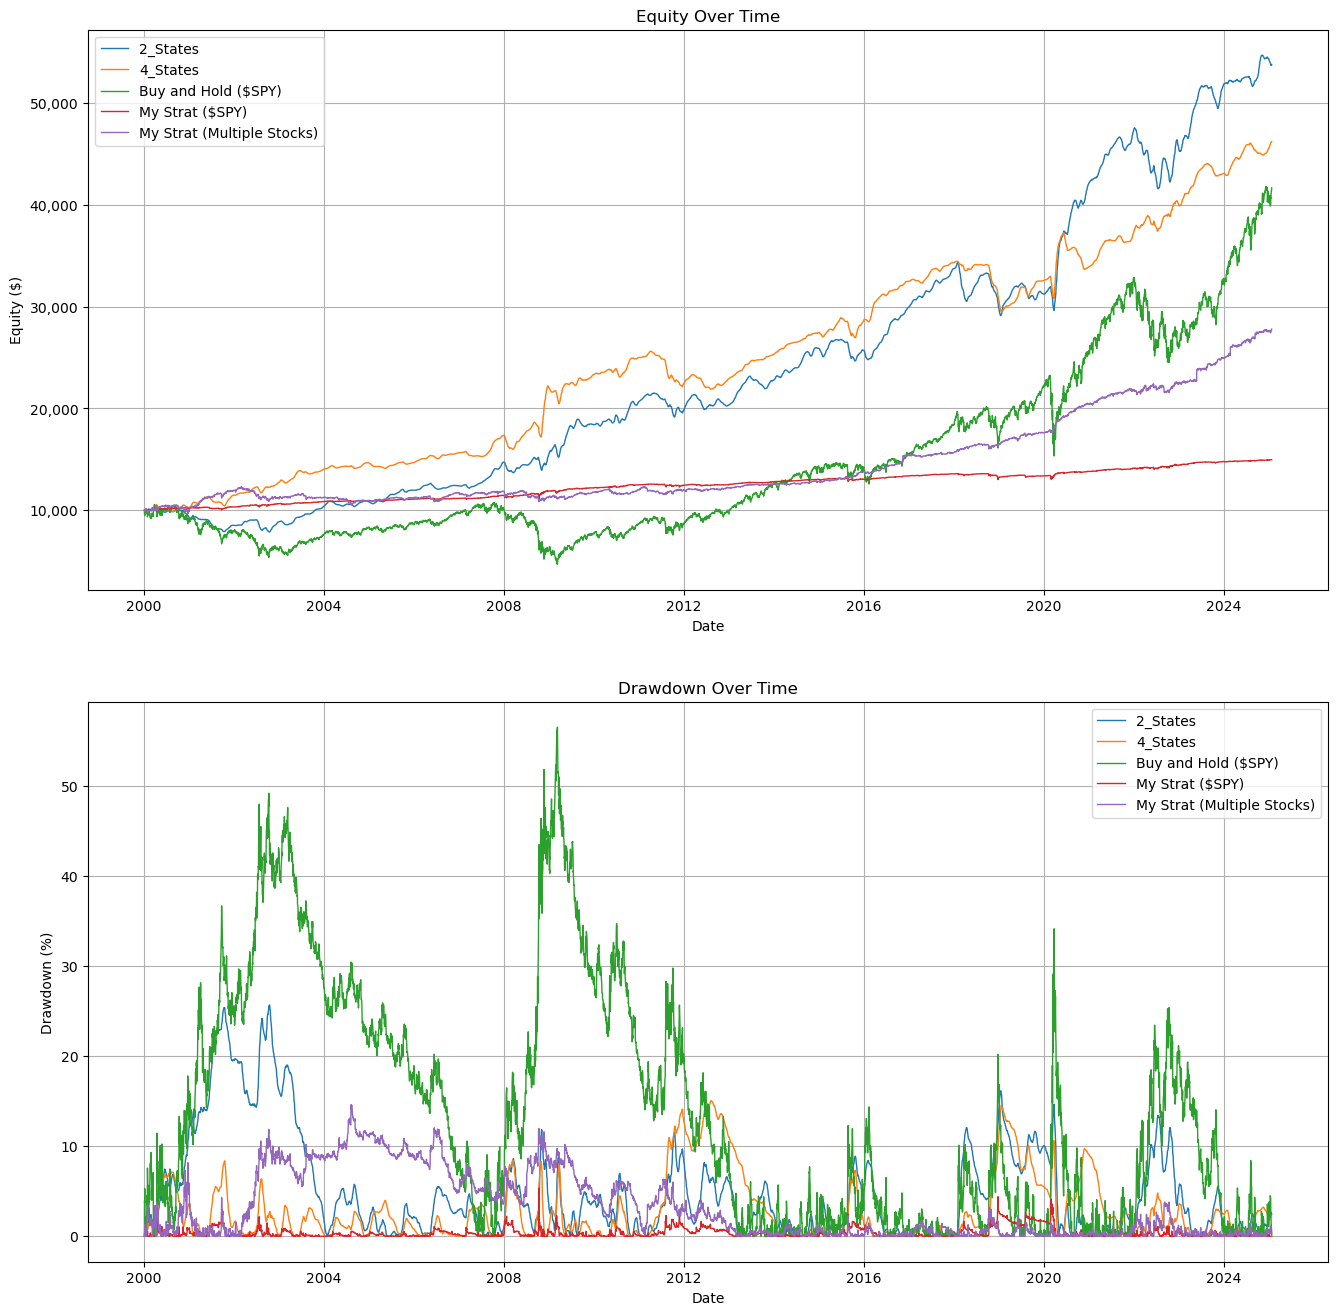

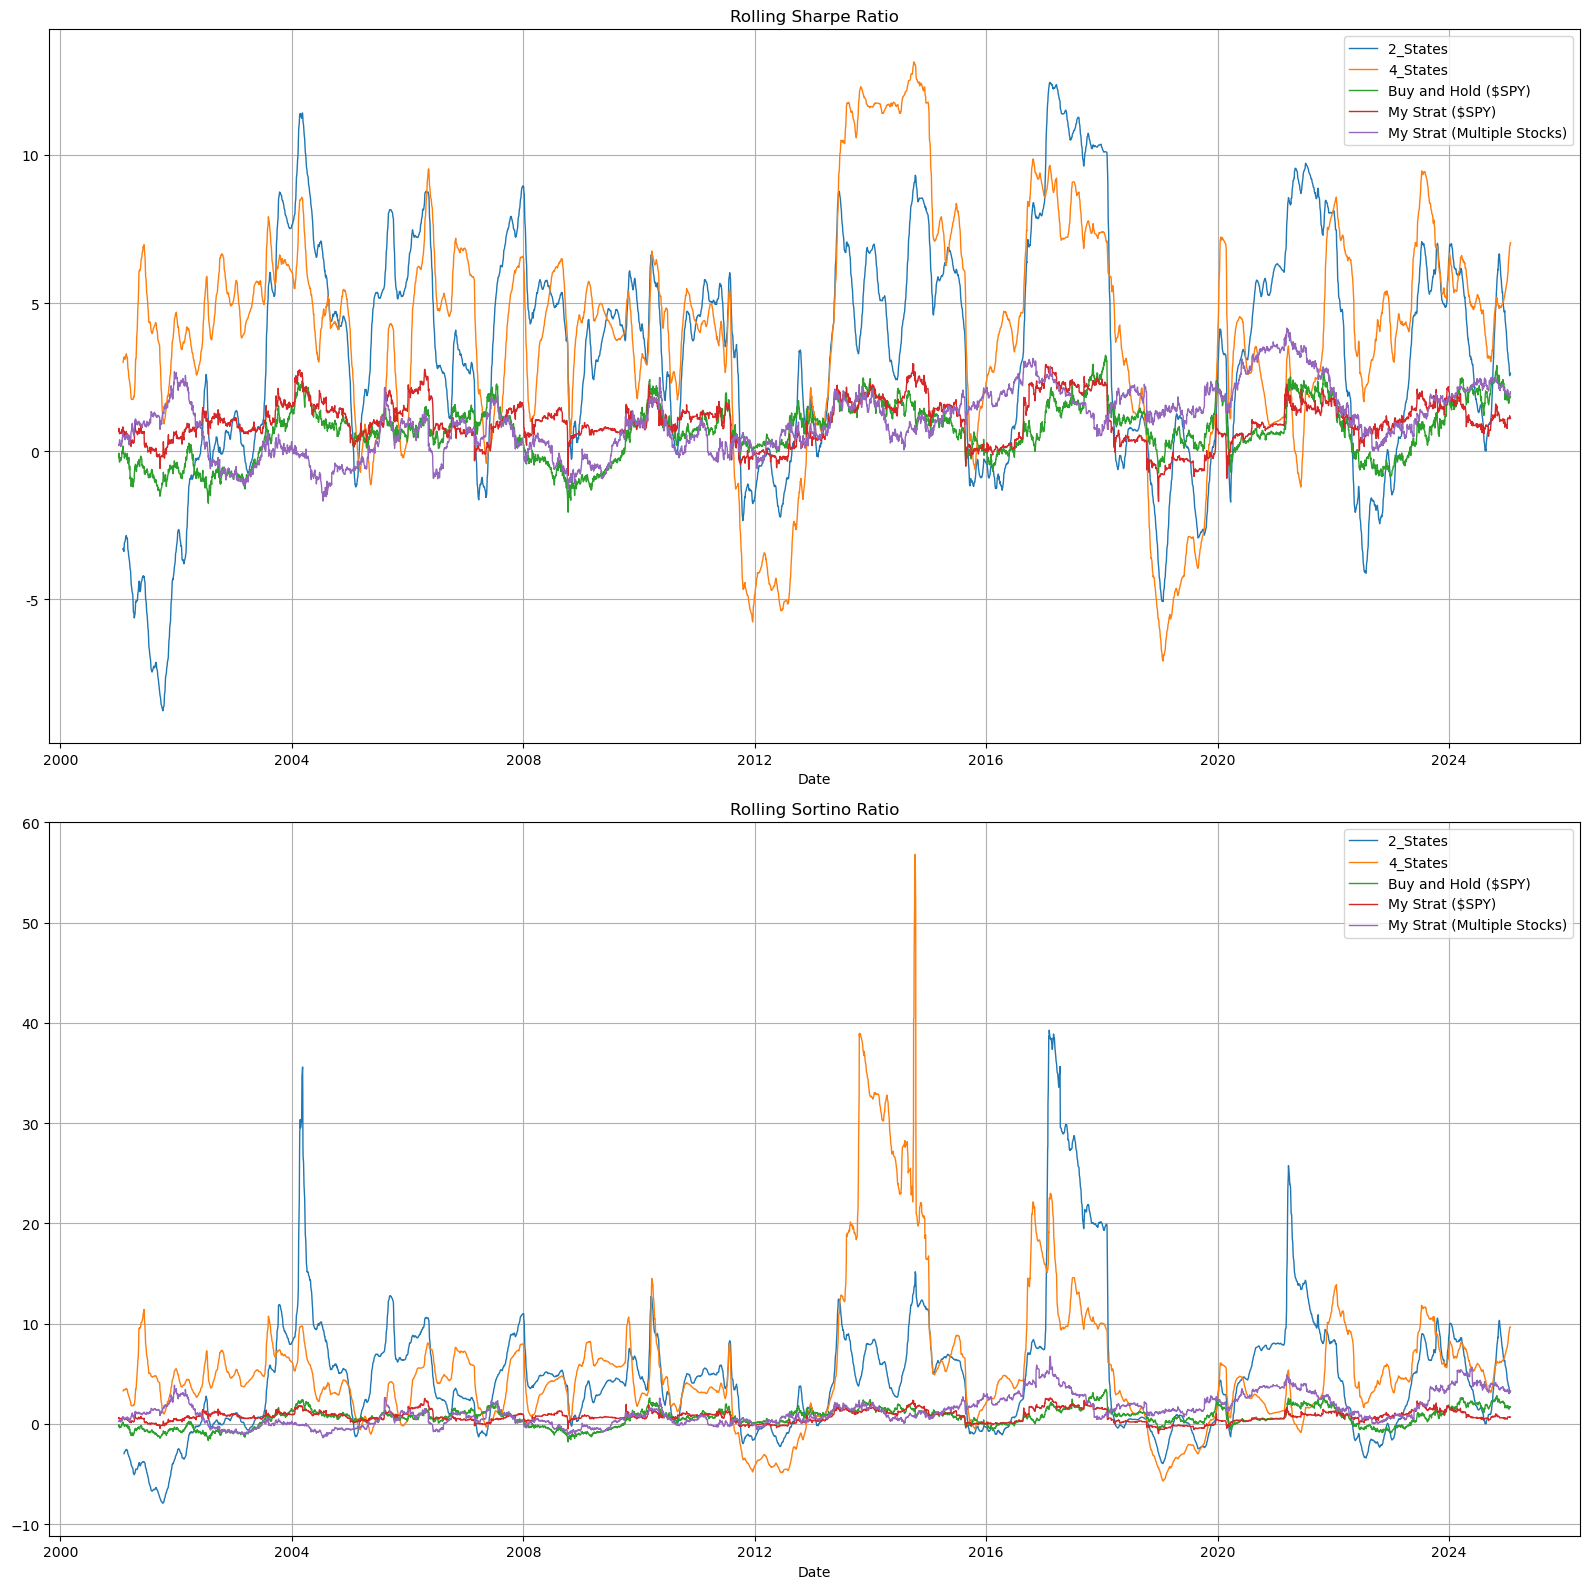

In [115]:
cash = 10000
ticker_symbol = "SPY"
start_date = "2000-01-01"
end_date = "2026-01-01"
ticker_symbols = ["NVDA", "MSFT", "DIS", "ORCL", "KO", "INTC", "MO"]
# ticker_symbols = ["SPY"]

multiplier = 1
max_relative = False

stock_data = download_stock_data(ticker_symbol, start_date, end_date)
kelly_percentages = calculate_kelly_criterion(stock_data)
print(f"Kelly Criterion (${ticker_symbol}): {kelly_percentages}")

state_columns = [col for col in stock_data.columns if re.match(r"^\d+_States$", col)]
state_numbers = [int(re.match(r"^(\d+)_States$", col).group(1)) for col in state_columns]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 16))
fig, (ax3, ax4) = plt.subplots(2, 1, figsize=(16, 16))

for state_column, state_number in zip(state_columns, state_numbers):
    if state_number in [2, 4]:
        date_record, equity_record, drawdown_record = simulate_strategy_using_states(cash, stock_data, state_number, multiplier=10000)
        sharpe_ratio = calculate_sharpe_ratio(equity_record)
        sortino_ratio = calculate_sortino_ratio(equity_record)
        print(f"For {state_column}")
        print(f" - Sharpe Ratio: {sharpe_ratio:.2f}")
        print(f" - Sortino Ratio: {sortino_ratio:.2f}")
        
        plot_states_comparison(ax1, ax2, state_column, date_record, equity_record, drawdown_record)
        plot_ratio_comparison(ax3, ax4, state_column, equity_record, date_record)
        annualized_return = calculate_annualized_return(date_record, equity_record)
        print(f" - Annualized Return: {annualized_return * 100:.2f}%")
    
date_record, equity_record, drawdown_record = simulate_buy_and_hold(cash, stock_data)
plot_states_comparison(ax1, ax2, f"Buy and Hold (${ticker_symbol})", date_record, equity_record, drawdown_record)
plot_ratio_comparison(ax3, ax4, f"Buy and Hold (${ticker_symbol})", equity_record, date_record)
sharpe_ratio = calculate_sharpe_ratio(equity_record)
sortino_ratio = calculate_sortino_ratio(equity_record)
print(f"For Buy and Hold")
print(f" - Sharpe Ratio: {sharpe_ratio:.2f}")
print(f" - Sortino Ratio: {sortino_ratio:.2f}")
annualized_return = calculate_annualized_return(date_record, equity_record)
print(f" - Annualized Return: {annualized_return * 100:.2f}%")

date_record, equity_record, drawdown_record = simulate_combined_strategy(cash, stock_data, multiplier, max_relative)
plot_states_comparison(ax1, ax2, f"My Strat (${ticker_symbol})", date_record, equity_record, drawdown_record)
plot_ratio_comparison(ax3, ax4, f"My Strat (${ticker_symbol})", equity_record, date_record)
sharpe_ratio = calculate_sharpe_ratio(equity_record)
sortino_ratio = calculate_sortino_ratio(equity_record)
print(f"For My Strategy")
print(f" - Sharpe Ratio: {sharpe_ratio:.2f}")
print(f" - Sortino Ratio: {sortino_ratio:.2f}")
annualized_return = calculate_annualized_return(date_record, equity_record)
print(f" - Annualized Return: {annualized_return * 100:.2f}%")

stock_data_list = []
for ticker_symbol in ticker_symbols:
    data = download_stock_data(ticker_symbol, start_date, end_date)
    stock_data_list.append(data)
date_record, equity_record, drawdown_record, trade_record = simulate_combined_strategy_basket(cash, stock_data_list, multiplier, max_relative)
plot_states_comparison(ax1, ax2, "My Strat (Multiple Stocks)", date_record, equity_record, drawdown_record)
plot_ratio_comparison(ax3, ax4, "My Strat (Multiple Stocks)", equity_record, date_record)
sharpe_ratio = calculate_sharpe_ratio(equity_record)
sortino_ratio = calculate_sortino_ratio(equity_record)
print(f"For My Strategy (Multiple Stocks)")
print(f" - Sharpe Ratio: {sharpe_ratio:.2f}")
print(f" - Sortino Ratio: {sortino_ratio:.2f}")
annualized_return = calculate_annualized_return(date_record, equity_record)
print(f" - Annualized Return: {annualized_return * 100:.2f}%")

plt.show()

In [107]:

ticker_symbols = ["NVDA", "MSFT", "DIS", "ORCL", "KO", "INTC", "MO"]
ticker_map = {index: symbol for index, symbol in enumerate(ticker_symbols)}

updated_trade_record = [
    {**d, "Ticker (Pos)": ticker_map.get(d["Ticker (Pos)"], d["Ticker (Pos)"])}  # Keep original if not in map
    for d in trade_record
]

df = pd.DataFrame(updated_trade_record)
df.tail(50)

Date Ticker (Pos)       Pct Signal
5655 2024-11-05         MSFT  0.007345      D
5656 2024-11-07           KO -0.000628      D
5657 2024-11-08           KO  0.004084     DD
5658 2024-11-11         NVDA -0.016054      D
5659 2024-11-12         NVDA  0.020859     DD
5660 2024-11-13           KO -0.003165     DD
5661 2024-11-14         NVDA  0.003350      D
5662 2024-11-15         ORCL -0.017696      D
5663 2024-11-18         NVDA -0.012889      D
5664 2024-11-19         NVDA  0.048948     DD
5665 2024-11-20          DIS  0.016367     DD
5666 2024-11-21         NVDA  0.005346      D
5667 2024-11-22         MSFT  0.010003     DD
5668 2024-11-25         NVDA -0.041775      D
5669 2024-11-26         NVDA  0.006617     DD
5670 2024-11-27          DIS  0.018623      D
5671 2024-11-29         NVDA  0.021501      D
5672 2024-12-02          DIS -0.002639      D
5673 2024-12-03          DIS -0.006060     DD
5674 2024-12-04          DIS  0.004637    DDD
5675 2024-12-05           KO  0.011413  DDDDD
5676 2024-12-06         NVDA -0.018061      D
5677 2024-12-09         NVDA -0.025484     DD
5678 2024-12-10         NVDA -0.026943    DDD
5679 2024-12-11         NVDA  0.031391   DDDD
5680 2024-12-12          DIS  0.002530      D
5681 2024-12-13         NVDA -0.022499      D
5682 2024-12-16         NVDA -0.016760     DD
5683 2024-12-17         NVDA -0.012197    DDD
5684 2024-12-18         NVDA -0.011351   DDDD
5685 2024-12-19         NVDA  0.013730  DDDDD
5686 2024-12-20         MSFT -0.000984     DD
5687 2024-12-23         MSFT -0.003092    DDD
5688 2024-12-24         MSFT  0.009374   DDDD
5689 2024-12-26           MO -0.016271     DD
5690 2024-12-27         NVDA -0.020868      D
5691 2024-12-30         NVDA  0.003503     DD
5692 2024-12-31         MSFT -0.007838    DDD
5693 2025-01-02         NVDA  0.029935      D
5694 2025-01-03         MSFT  0.011396  DDDDD
5695 2025-01-06           KO -0.015223     DD
5696 2025-01-07          DIS  0.003062      D
5697 2025-01-08         NVDA -0.000214      D
5698 2025-01-10         NVDA -0.029976     DD
5699 2025-01-13         NVDA -0.019719    DDD
5700 2025-01-14         NVDA -0.011034   DDDD
5701 2025-01-15         NVDA  0.034001  DDDDD
5702 2025-01-16           KO  0.007771      D
5703 2025-01-17         NVDA  0.030995      D
5704 2025-01-22         MSFT  0.041307      D

Downloaded $SPY, starting from 2010-01-04 to 2025-01-22
Kelly Criterion ($SPY): {'2_States': 0.08830374499211263, '4_States': 0.10948394020300273, '8_States': 0.17795324509761573, '16_States': 0.20633612070167234, '32_States': 0.289702822440608}
For 2_States
 - Sharpe Ratio: 0.62
 - Sortino Ratio: 0.89
 - Annualized Return: 6.96%
For 4_States
 - Sharpe Ratio: 0.51
 - Sortino Ratio: 0.75
 - Annualized Return: 4.33%
For Buy and Hold
 - Sharpe Ratio: 0.74
 - Sortino Ratio: 1.03
 - Annualized Return: 11.05%
For My Strategy
 - Sharpe Ratio: 0.70
 - Sortino Ratio: 1.05
 - Annualized Return: 1.16%
Downloaded $NVDA, starting from 2010-01-04 to 2025-01-22
Downloaded $MSFT, starting from 2010-01-04 to 2025-01-22
Downloaded $DIS, starting from 2010-01-04 to 2025-01-22
Downloaded $ORCL, starting from 2010-01-04 to 2025-01-22
Downloaded $KO, starting from 2010-01-04 to 2025-01-22
Downloaded $INTC, starting from 2010-01-04 to 2025-01-22
Downloaded $MO, starting from 2010-01-04 to 2025-01-22
For My S

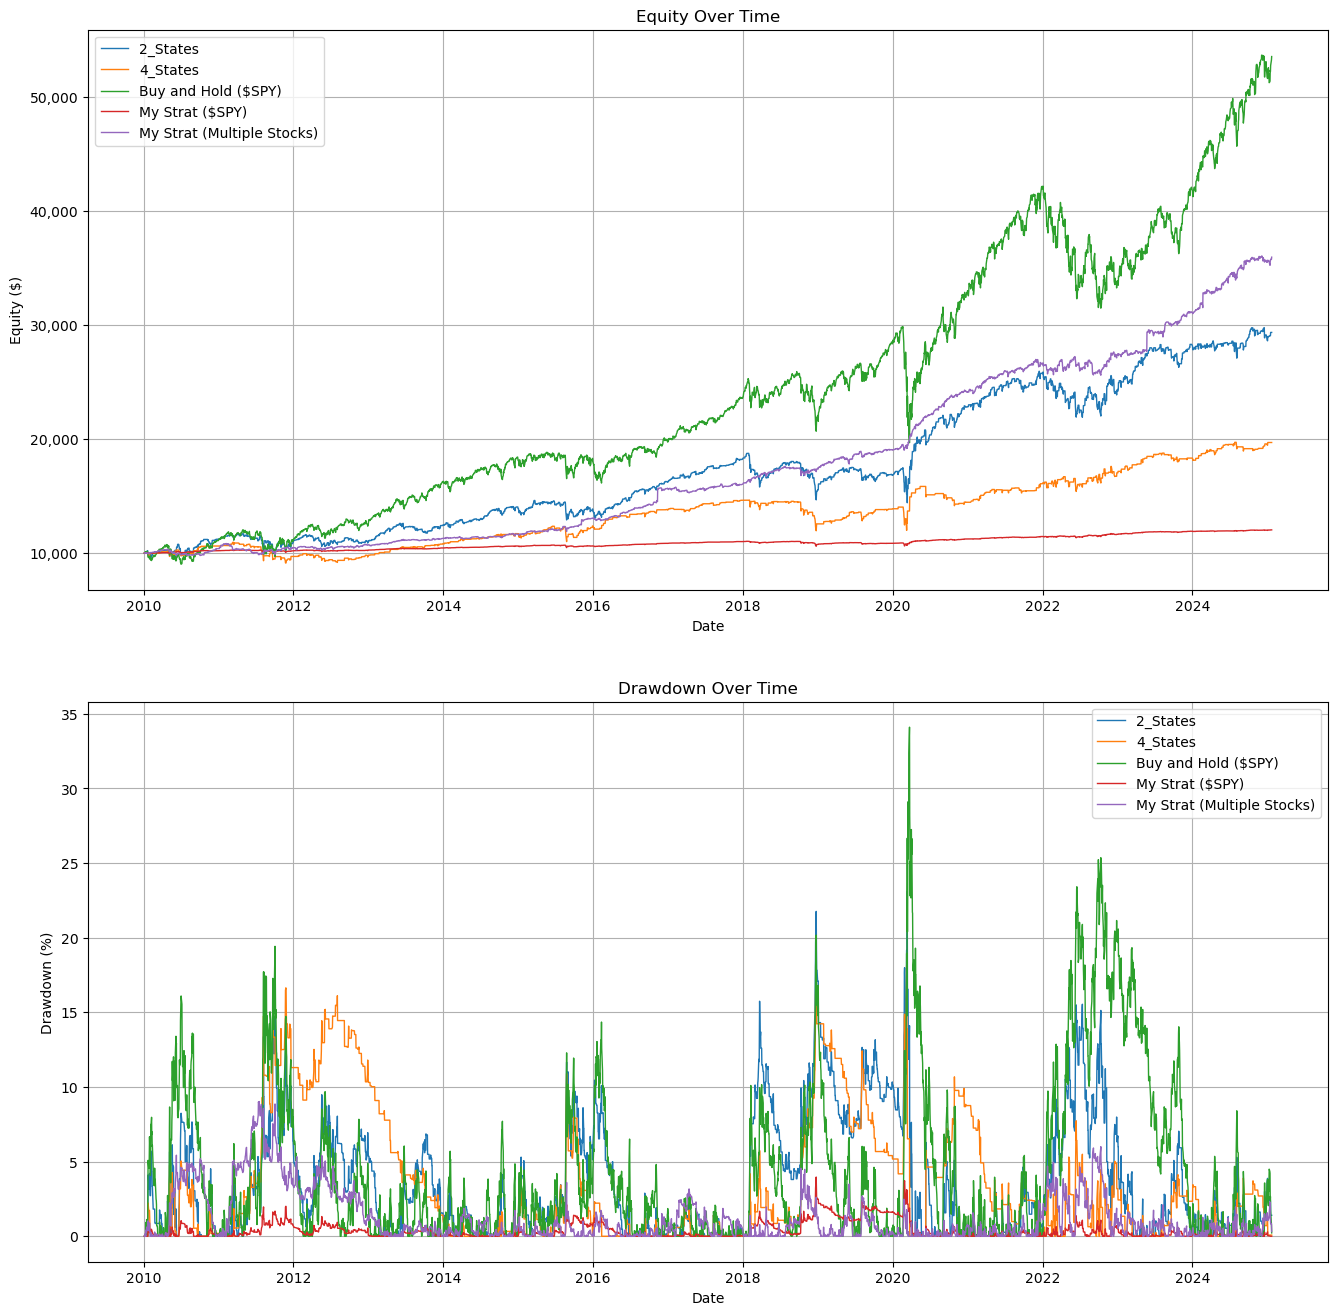

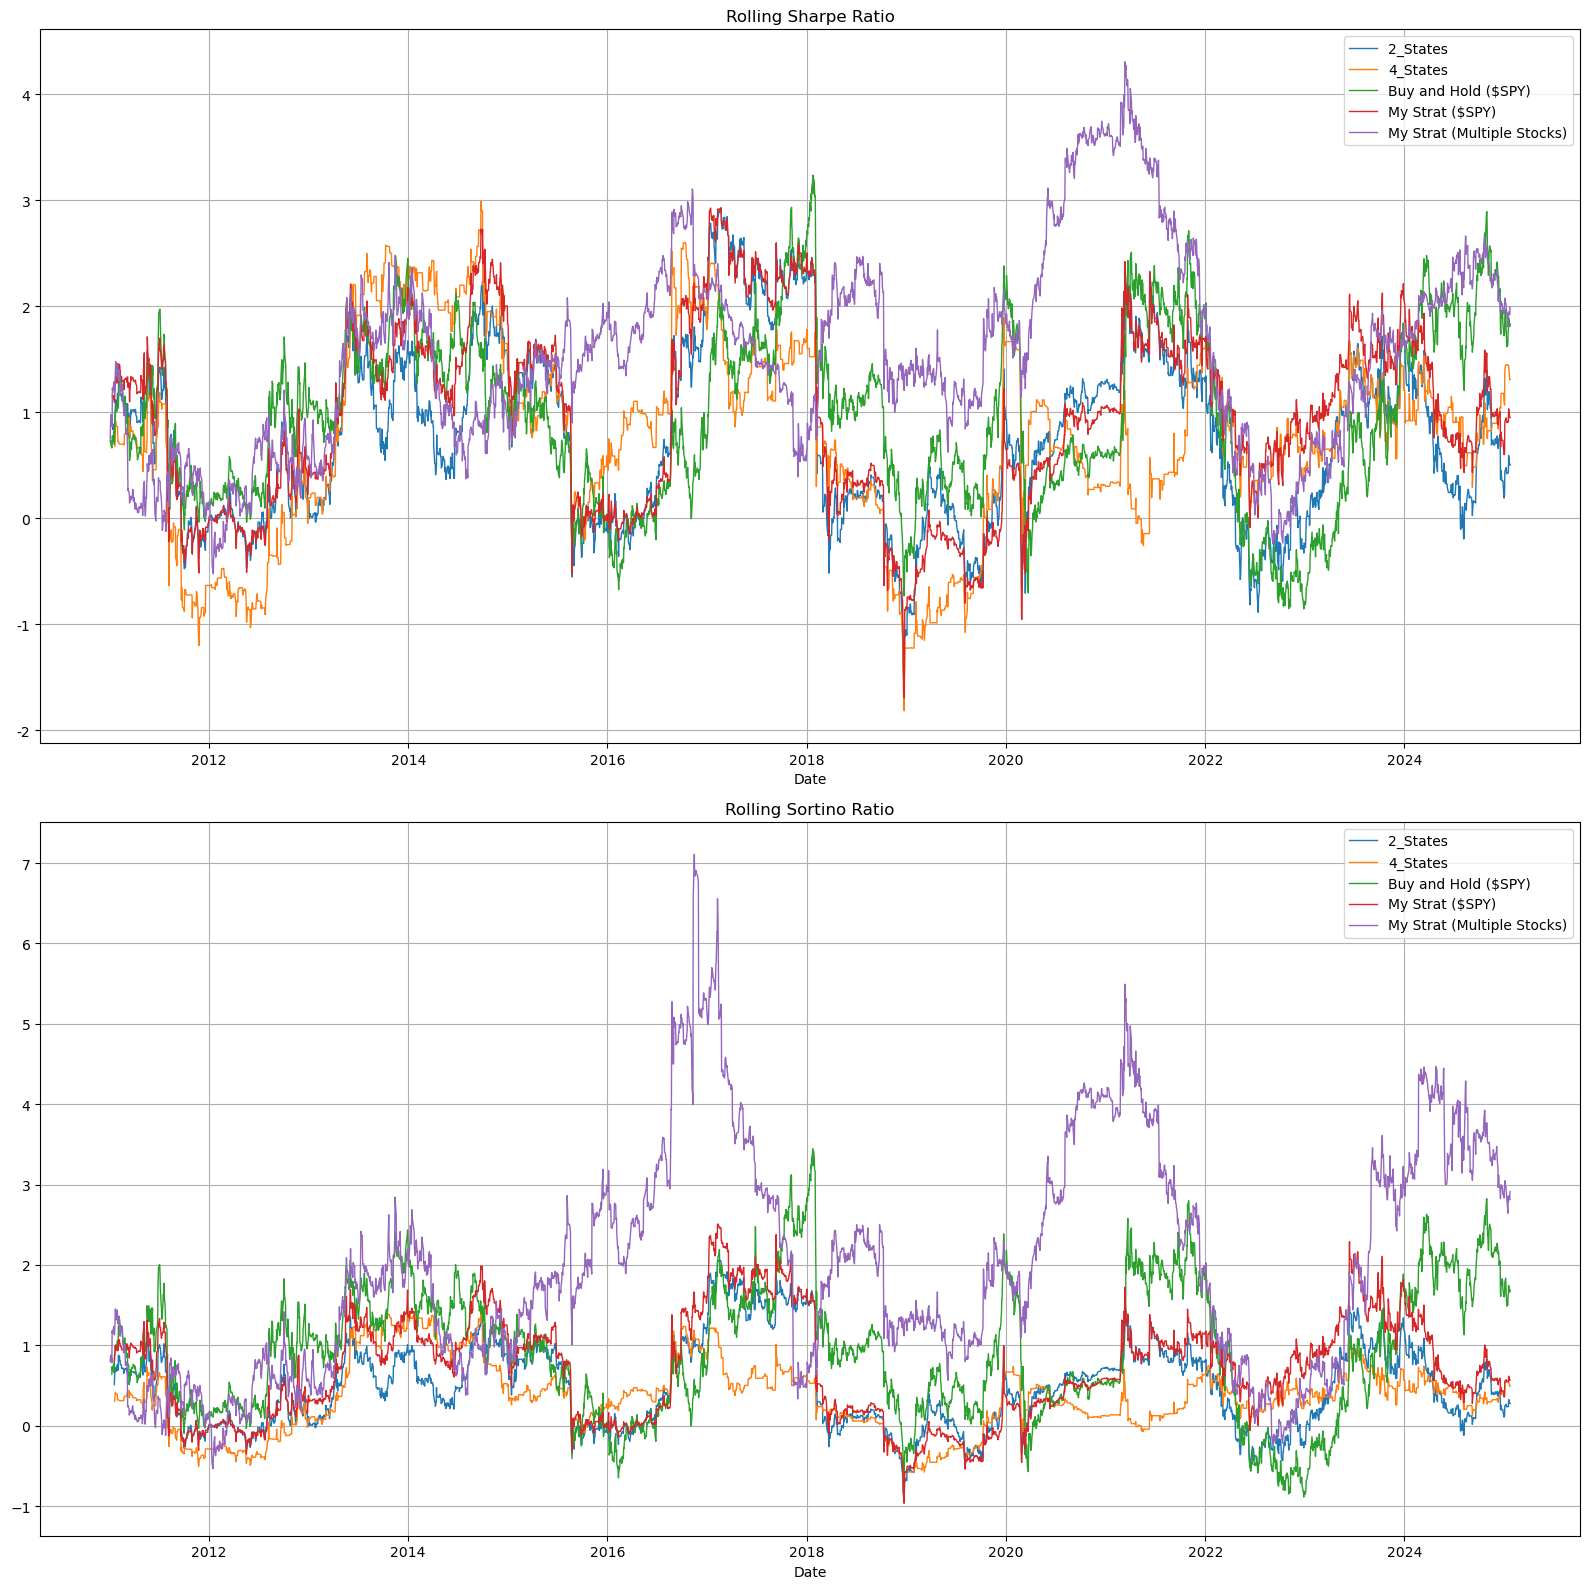

In [108]:
cash = 10000
ticker_symbol = "SPY"
start_date = "2010-01-01"
end_date = "2026-01-01"
ticker_symbols = ["NVDA", "MSFT", "DIS", "ORCL", "KO", "INTC", "MO"]
# ticker_symbols = ["SPY"]

multiplier = 1
max_relative = False

stock_data = download_stock_data(ticker_symbol, start_date, end_date)
kelly_percentages = calculate_kelly_criterion(stock_data)
print(f"Kelly Criterion (${ticker_symbol}): {kelly_percentages}")

state_columns = [col for col in stock_data.columns if re.match(r"^\d+_States$", col)]
state_numbers = [int(re.match(r"^(\d+)_States$", col).group(1)) for col in state_columns]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 16))
fig, (ax3, ax4) = plt.subplots(2, 1, figsize=(16, 16))

for state_column, state_number in zip(state_columns, state_numbers):
    if state_number in [2, 4]:
        date_record, equity_record, drawdown_record = simulate_strategy_using_states(cash, stock_data, state_number, multiplier=10000)
        sharpe_ratio = calculate_sharpe_ratio(equity_record)
        sortino_ratio = calculate_sortino_ratio(equity_record)
        print(f"For {state_column}")
        print(f" - Sharpe Ratio: {sharpe_ratio:.2f}")
        print(f" - Sortino Ratio: {sortino_ratio:.2f}")
        
        plot_states_comparison(ax1, ax2, state_column, date_record, equity_record, drawdown_record)
        plot_ratio_comparison(ax3, ax4, state_column, equity_record, date_record)
        annualized_return = calculate_annualized_return(date_record, equity_record)
        print(f" - Annualized Return: {annualized_return * 100:.2f}%")
    
date_record, equity_record, drawdown_record = simulate_buy_and_hold(cash, stock_data)
plot_states_comparison(ax1, ax2, f"Buy and Hold (${ticker_symbol})", date_record, equity_record, drawdown_record)
plot_ratio_comparison(ax3, ax4, f"Buy and Hold (${ticker_symbol})", equity_record, date_record)
sharpe_ratio = calculate_sharpe_ratio(equity_record)
sortino_ratio = calculate_sortino_ratio(equity_record)
print(f"For Buy and Hold")
print(f" - Sharpe Ratio: {sharpe_ratio:.2f}")
print(f" - Sortino Ratio: {sortino_ratio:.2f}")
annualized_return = calculate_annualized_return(date_record, equity_record)
print(f" - Annualized Return: {annualized_return * 100:.2f}%")

date_record, equity_record, drawdown_record = simulate_combined_strategy(cash, stock_data, multiplier, max_relative)
plot_states_comparison(ax1, ax2, f"My Strat (${ticker_symbol})", date_record, equity_record, drawdown_record)
plot_ratio_comparison(ax3, ax4, f"My Strat (${ticker_symbol})", equity_record, date_record)
sharpe_ratio = calculate_sharpe_ratio(equity_record)
sortino_ratio = calculate_sortino_ratio(equity_record)
print(f"For My Strategy")
print(f" - Sharpe Ratio: {sharpe_ratio:.2f}")
print(f" - Sortino Ratio: {sortino_ratio:.2f}")
annualized_return = calculate_annualized_return(date_record, equity_record)
print(f" - Annualized Return: {annualized_return * 100:.2f}%")

stock_data_list = []
for ticker_symbol in ticker_symbols:
    data = download_stock_data(ticker_symbol, start_date, end_date)
    stock_data_list.append(data)
date_record, equity_record, drawdown_record, trade_record = simulate_combined_strategy_basket(cash, stock_data_list, multiplier, max_relative)
plot_states_comparison(ax1, ax2, "My Strat (Multiple Stocks)", date_record, equity_record, drawdown_record)
plot_ratio_comparison(ax3, ax4, "My Strat (Multiple Stocks)", equity_record, date_record)
sharpe_ratio = calculate_sharpe_ratio(equity_record)
sortino_ratio = calculate_sortino_ratio(equity_record)
print(f"For My Strategy (Multiple Stocks)")
print(f" - Sharpe Ratio: {sharpe_ratio:.2f}")
print(f" - Sortino Ratio: {sortino_ratio:.2f}")
annualized_return = calculate_annualized_return(date_record, equity_record)
print(f" - Annualized Return: {annualized_return * 100:.2f}%")

plt.show()

Downloaded $SPY, starting from 2010-01-04 to 2025-01-22
Kelly Criterion ($SPY): {'2_States': 0.08830374499211263, '4_States': 0.10948394020300273, '8_States': 0.17795324509761573, '16_States': 0.20633612070167234, '32_States': 0.289702822440608}
For 2_States
 - Sharpe Ratio: 0.62
 - Sortino Ratio: 0.89
 - Annualized Return: 6.96%
For 4_States
 - Sharpe Ratio: 0.51
 - Sortino Ratio: 0.75
 - Annualized Return: 4.33%
For Buy and Hold
 - Sharpe Ratio: 0.74
 - Sortino Ratio: 1.03
 - Annualized Return: 11.05%
For My Strategy
 - Sharpe Ratio: 0.70
 - Sortino Ratio: 1.05
 - Annualized Return: 2.31%
Downloaded $NVDA, starting from 2010-01-04 to 2025-01-22
Downloaded $MSFT, starting from 2010-01-04 to 2025-01-22
Downloaded $DIS, starting from 2010-01-04 to 2025-01-22
Downloaded $ORCL, starting from 2010-01-04 to 2025-01-22
Downloaded $KO, starting from 2010-01-04 to 2025-01-22
Downloaded $INTC, starting from 2010-01-04 to 2025-01-22
Downloaded $MO, starting from 2010-01-04 to 2025-01-22
For My S

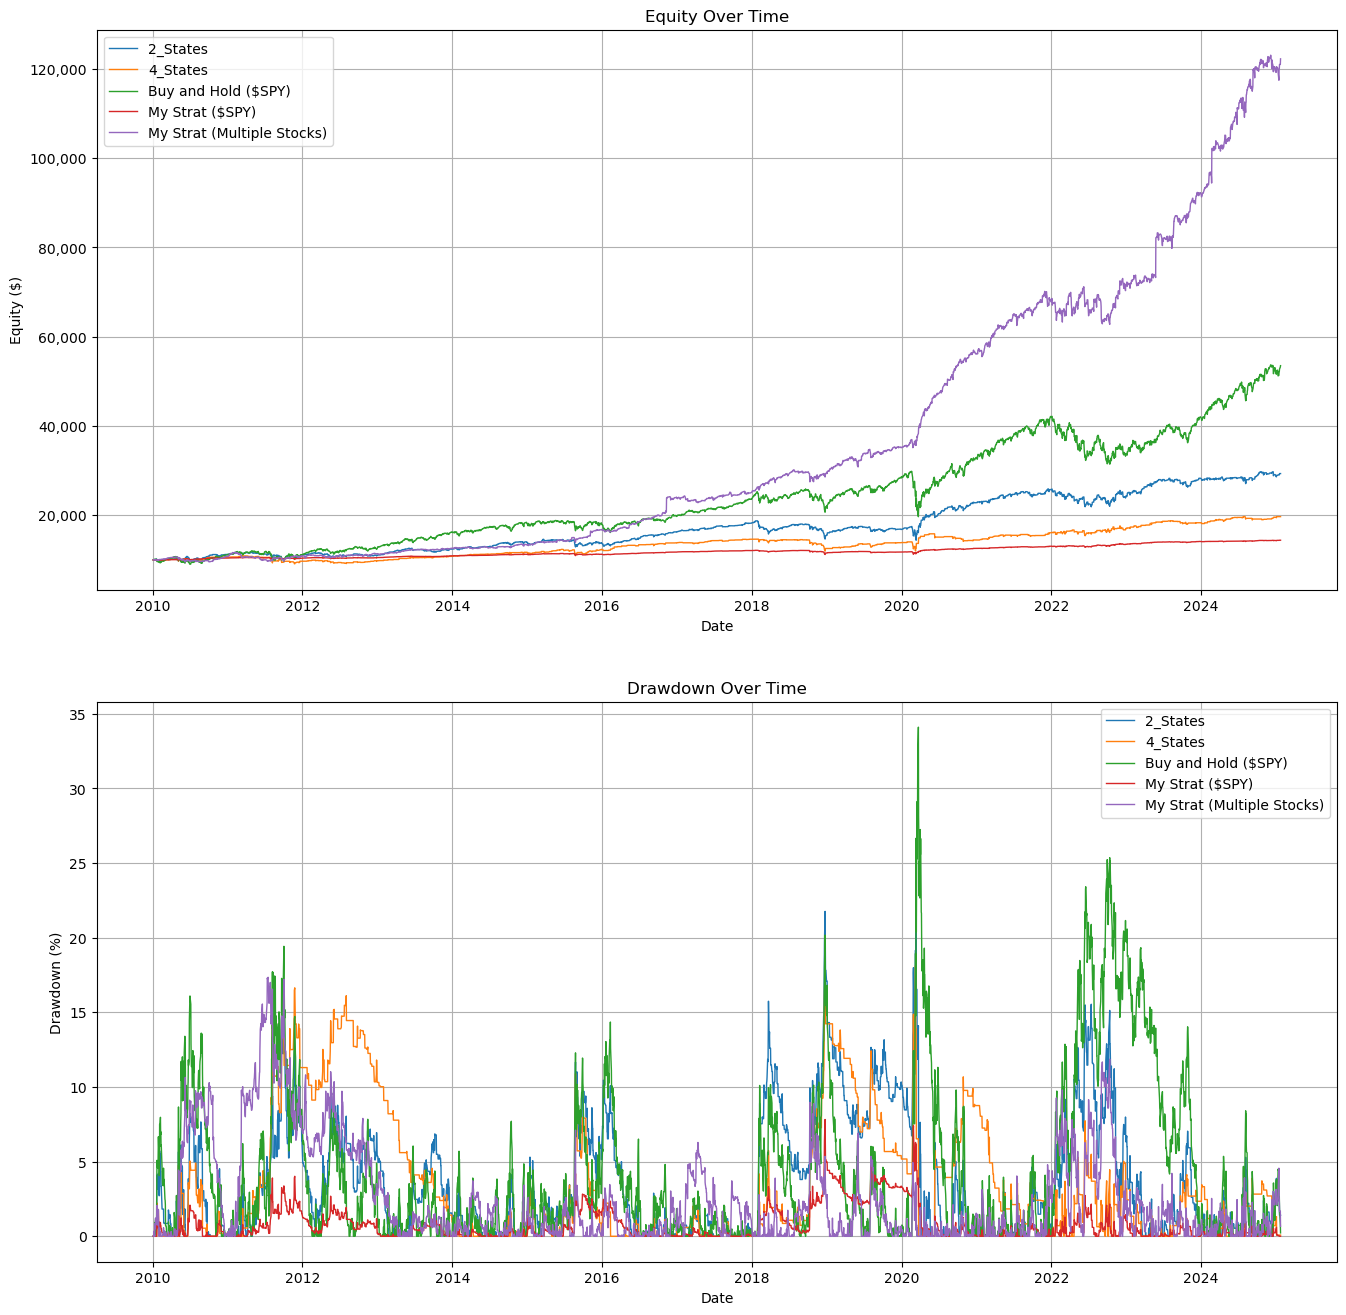

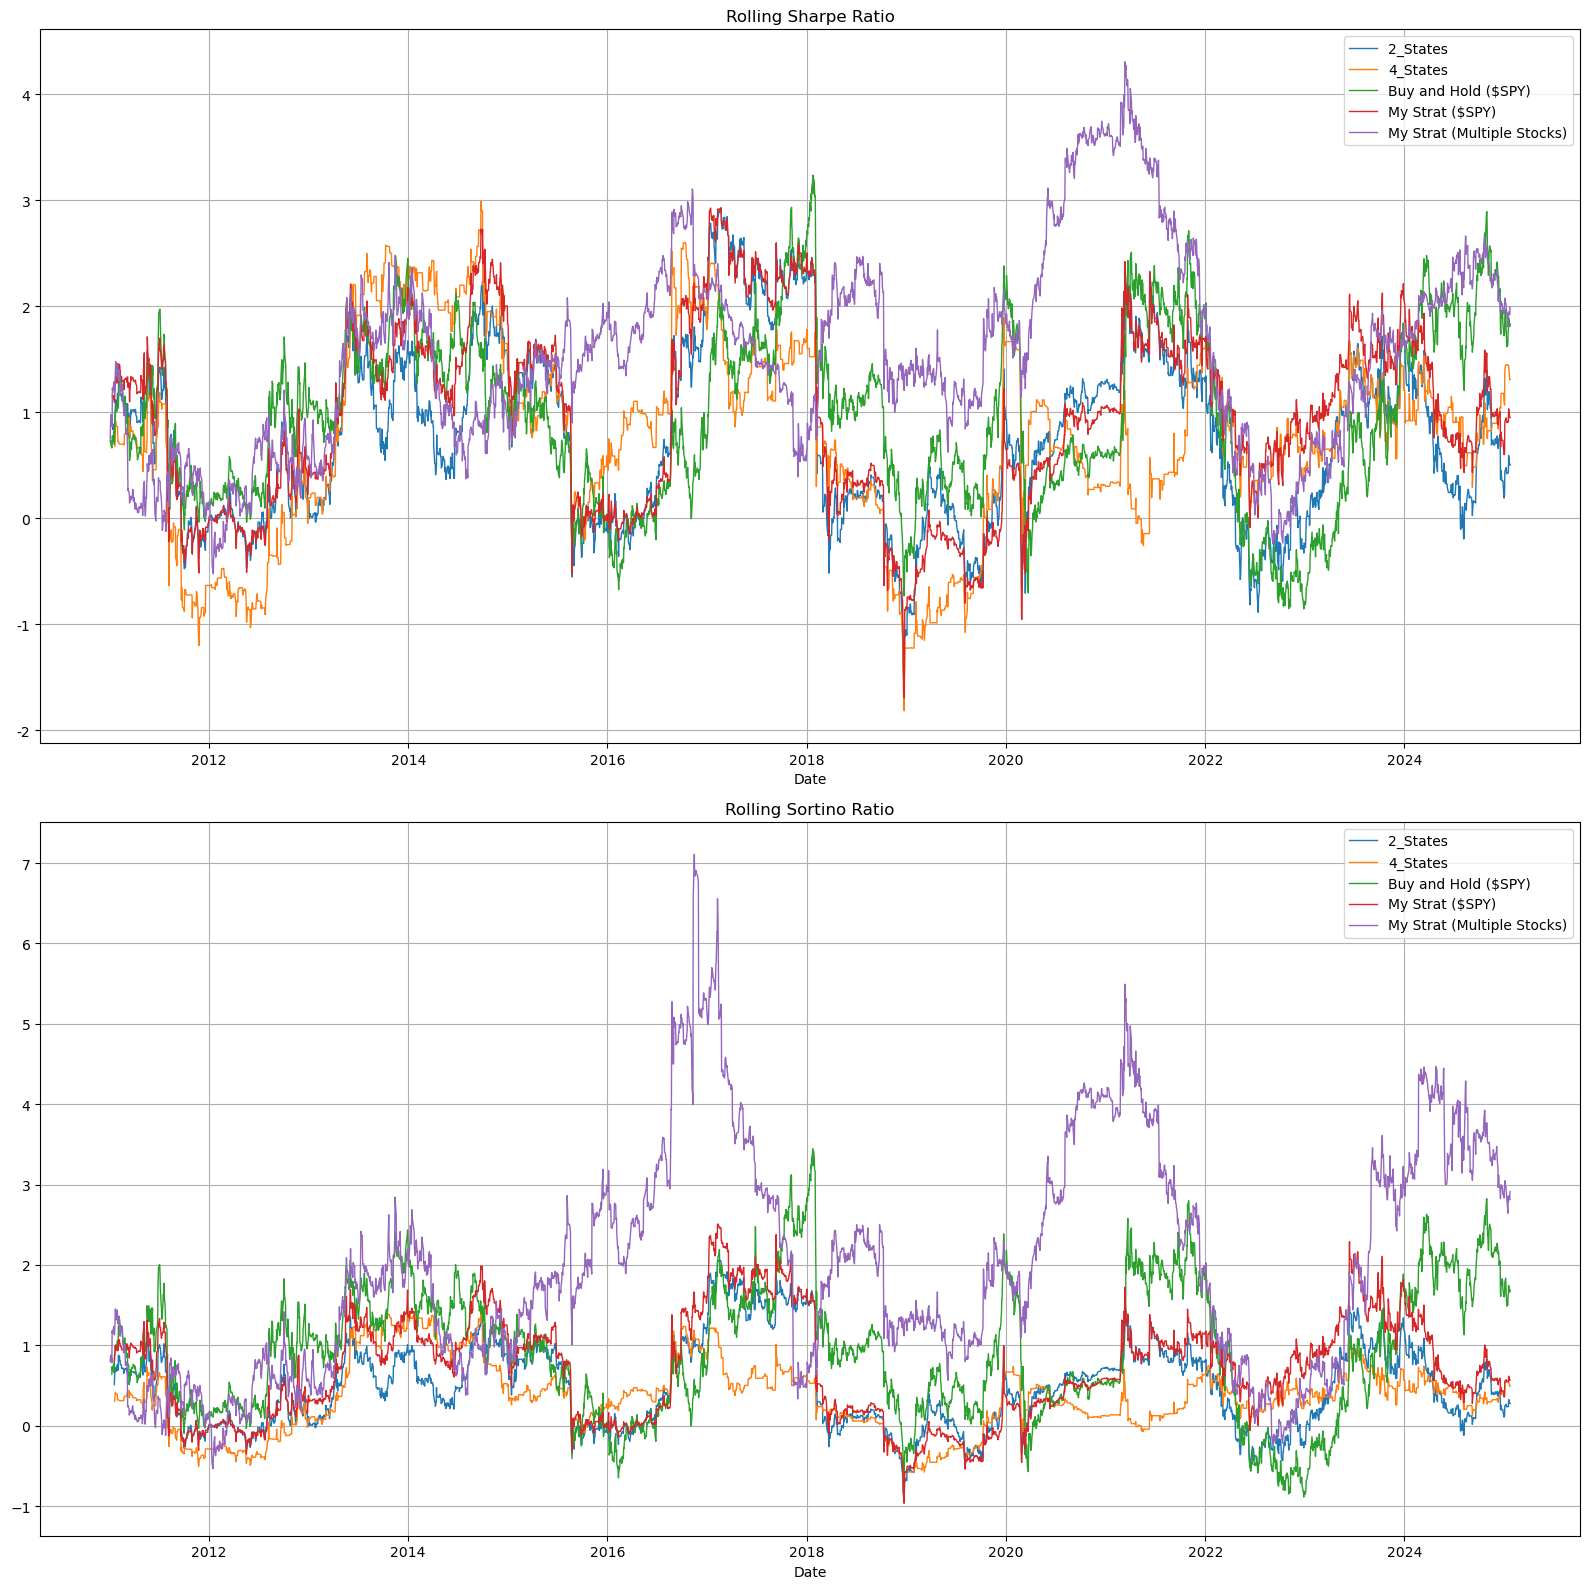

In [110]:
cash = 10000
ticker_symbol = "SPY"
start_date = "2010-01-01"
end_date = "2026-01-01"
ticker_symbols = ["NVDA", "MSFT", "DIS", "ORCL", "KO", "INTC", "MO"]
# ticker_symbols = ["SPY"]

multiplier = 2
max_relative = False

stock_data = download_stock_data(ticker_symbol, start_date, end_date)
kelly_percentages = calculate_kelly_criterion(stock_data)
print(f"Kelly Criterion (${ticker_symbol}): {kelly_percentages}")

state_columns = [col for col in stock_data.columns if re.match(r"^\d+_States$", col)]
state_numbers = [int(re.match(r"^(\d+)_States$", col).group(1)) for col in state_columns]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 16))
fig, (ax3, ax4) = plt.subplots(2, 1, figsize=(16, 16))

for state_column, state_number in zip(state_columns, state_numbers):
    if state_number in [2, 4]:
        date_record, equity_record, drawdown_record = simulate_strategy_using_states(cash, stock_data, state_number, multiplier=10000)
        sharpe_ratio = calculate_sharpe_ratio(equity_record)
        sortino_ratio = calculate_sortino_ratio(equity_record)
        print(f"For {state_column}")
        print(f" - Sharpe Ratio: {sharpe_ratio:.2f}")
        print(f" - Sortino Ratio: {sortino_ratio:.2f}")
        
        plot_states_comparison(ax1, ax2, state_column, date_record, equity_record, drawdown_record)
        plot_ratio_comparison(ax3, ax4, state_column, equity_record, date_record)
        annualized_return = calculate_annualized_return(date_record, equity_record)
        print(f" - Annualized Return: {annualized_return * 100:.2f}%")
    
date_record, equity_record, drawdown_record = simulate_buy_and_hold(cash, stock_data)
plot_states_comparison(ax1, ax2, f"Buy and Hold (${ticker_symbol})", date_record, equity_record, drawdown_record)
plot_ratio_comparison(ax3, ax4, f"Buy and Hold (${ticker_symbol})", equity_record, date_record)
sharpe_ratio = calculate_sharpe_ratio(equity_record)
sortino_ratio = calculate_sortino_ratio(equity_record)
print(f"For Buy and Hold")
print(f" - Sharpe Ratio: {sharpe_ratio:.2f}")
print(f" - Sortino Ratio: {sortino_ratio:.2f}")
annualized_return = calculate_annualized_return(date_record, equity_record)
print(f" - Annualized Return: {annualized_return * 100:.2f}%")

date_record, equity_record, drawdown_record = simulate_combined_strategy(cash, stock_data, multiplier, max_relative)
plot_states_comparison(ax1, ax2, f"My Strat (${ticker_symbol})", date_record, equity_record, drawdown_record)
plot_ratio_comparison(ax3, ax4, f"My Strat (${ticker_symbol})", equity_record, date_record)
sharpe_ratio = calculate_sharpe_ratio(equity_record)
sortino_ratio = calculate_sortino_ratio(equity_record)
print(f"For My Strategy")
print(f" - Sharpe Ratio: {sharpe_ratio:.2f}")
print(f" - Sortino Ratio: {sortino_ratio:.2f}")
annualized_return = calculate_annualized_return(date_record, equity_record)
print(f" - Annualized Return: {annualized_return * 100:.2f}%")

stock_data_list = []
for ticker_symbol in ticker_symbols:
    data = download_stock_data(ticker_symbol, start_date, end_date)
    stock_data_list.append(data)
date_record, equity_record, drawdown_record, trade_record = simulate_combined_strategy_basket(cash, stock_data_list, multiplier, max_relative)
plot_states_comparison(ax1, ax2, "My Strat (Multiple Stocks)", date_record, equity_record, drawdown_record)
plot_ratio_comparison(ax3, ax4, "My Strat (Multiple Stocks)", equity_record, date_record)
sharpe_ratio = calculate_sharpe_ratio(equity_record)
sortino_ratio = calculate_sortino_ratio(equity_record)
print(f"For My Strategy (Multiple Stocks)")
print(f" - Sharpe Ratio: {sharpe_ratio:.2f}")
print(f" - Sortino Ratio: {sortino_ratio:.2f}")
annualized_return = calculate_annualized_return(date_record, equity_record)
print(f" - Annualized Return: {annualized_return * 100:.2f}%")

plt.show()

Downloaded $SPY, starting from 2010-01-04 to 2025-01-22
Kelly Criterion ($SPY): {'2_States': 0.08830374499211263, '4_States': 0.10948394020300273, '8_States': 0.17795324509761573, '16_States': 0.20633612070167234, '32_States': 0.289702822440608}
For 2_States
 - Sharpe Ratio: 0.62
 - Sortino Ratio: 0.89
 - Annualized Return: 6.96%
For 4_States
 - Sharpe Ratio: 0.51
 - Sortino Ratio: 0.75
 - Annualized Return: 4.33%
For Buy and Hold
 - Sharpe Ratio: 0.74
 - Sortino Ratio: 1.03
 - Annualized Return: 11.05%
For My Strategy
 - Sharpe Ratio: 0.70
 - Sortino Ratio: 1.05
 - Annualized Return: 3.94%
Downloaded $NVDA, starting from 2010-01-04 to 2025-01-22
Downloaded $MSFT, starting from 2010-01-04 to 2025-01-22
Downloaded $DIS, starting from 2010-01-04 to 2025-01-22
Downloaded $ORCL, starting from 2010-01-04 to 2025-01-22
Downloaded $KO, starting from 2010-01-04 to 2025-01-22
Downloaded $INTC, starting from 2010-01-04 to 2025-01-22
Downloaded $MO, starting from 2010-01-04 to 2025-01-22
For My S

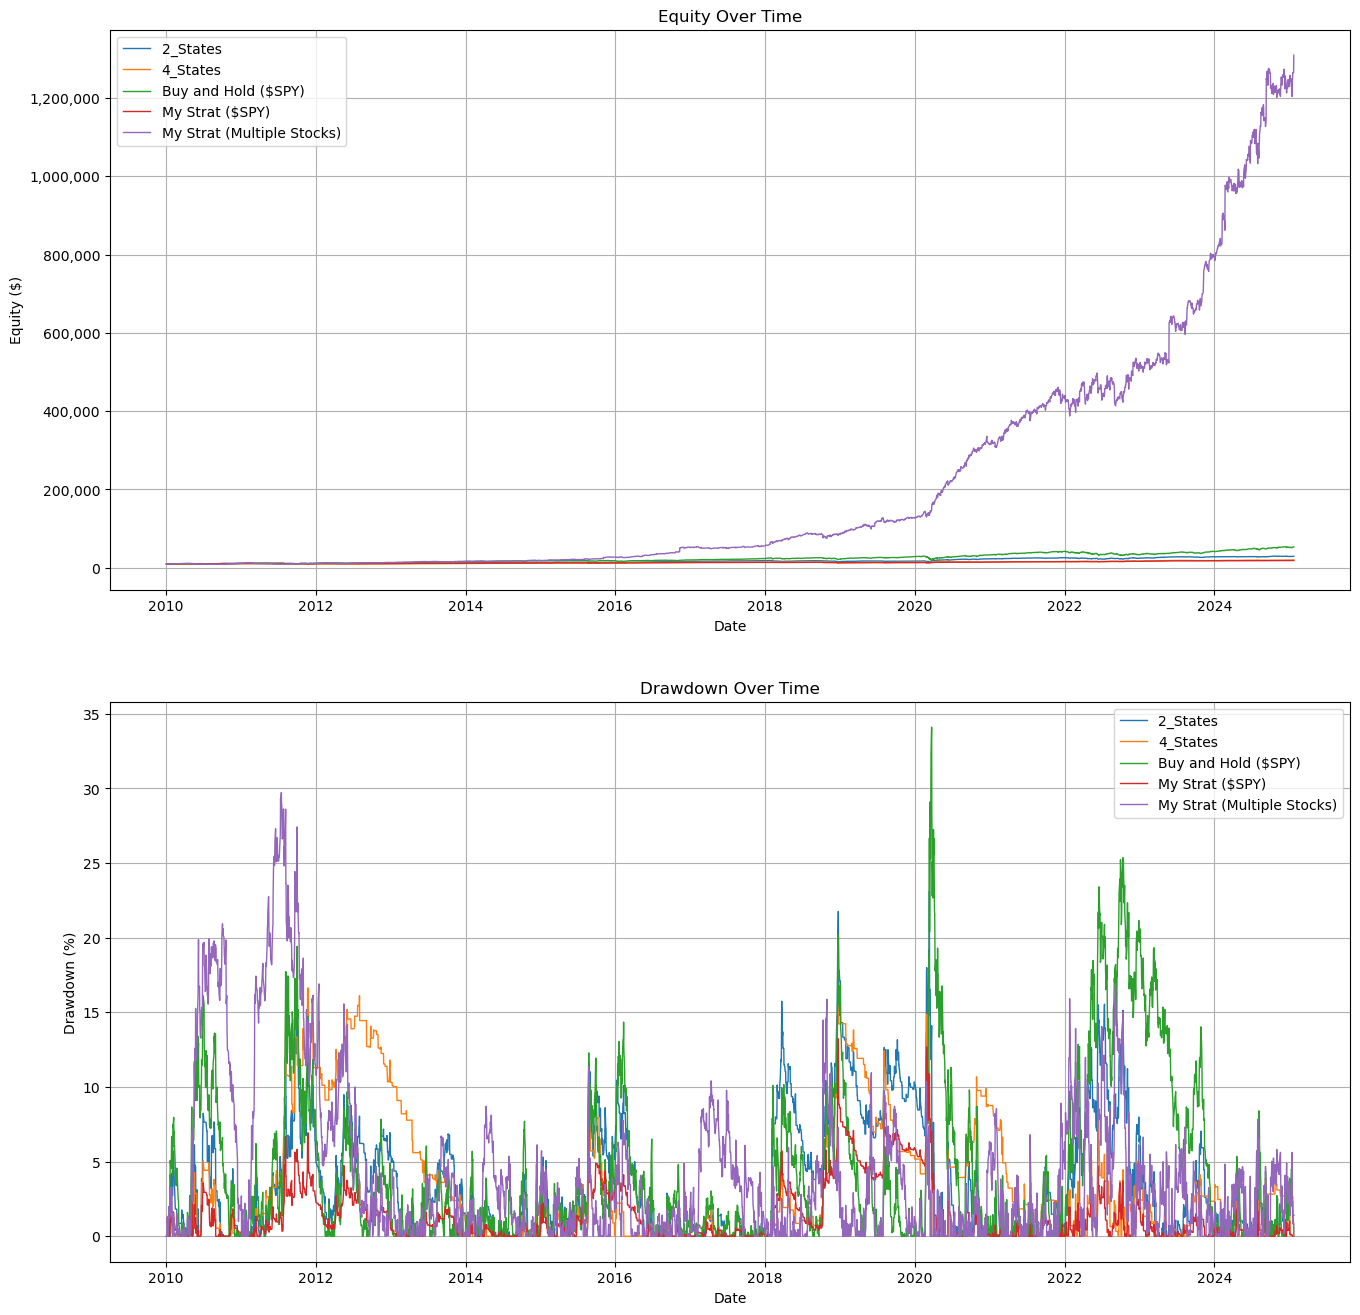

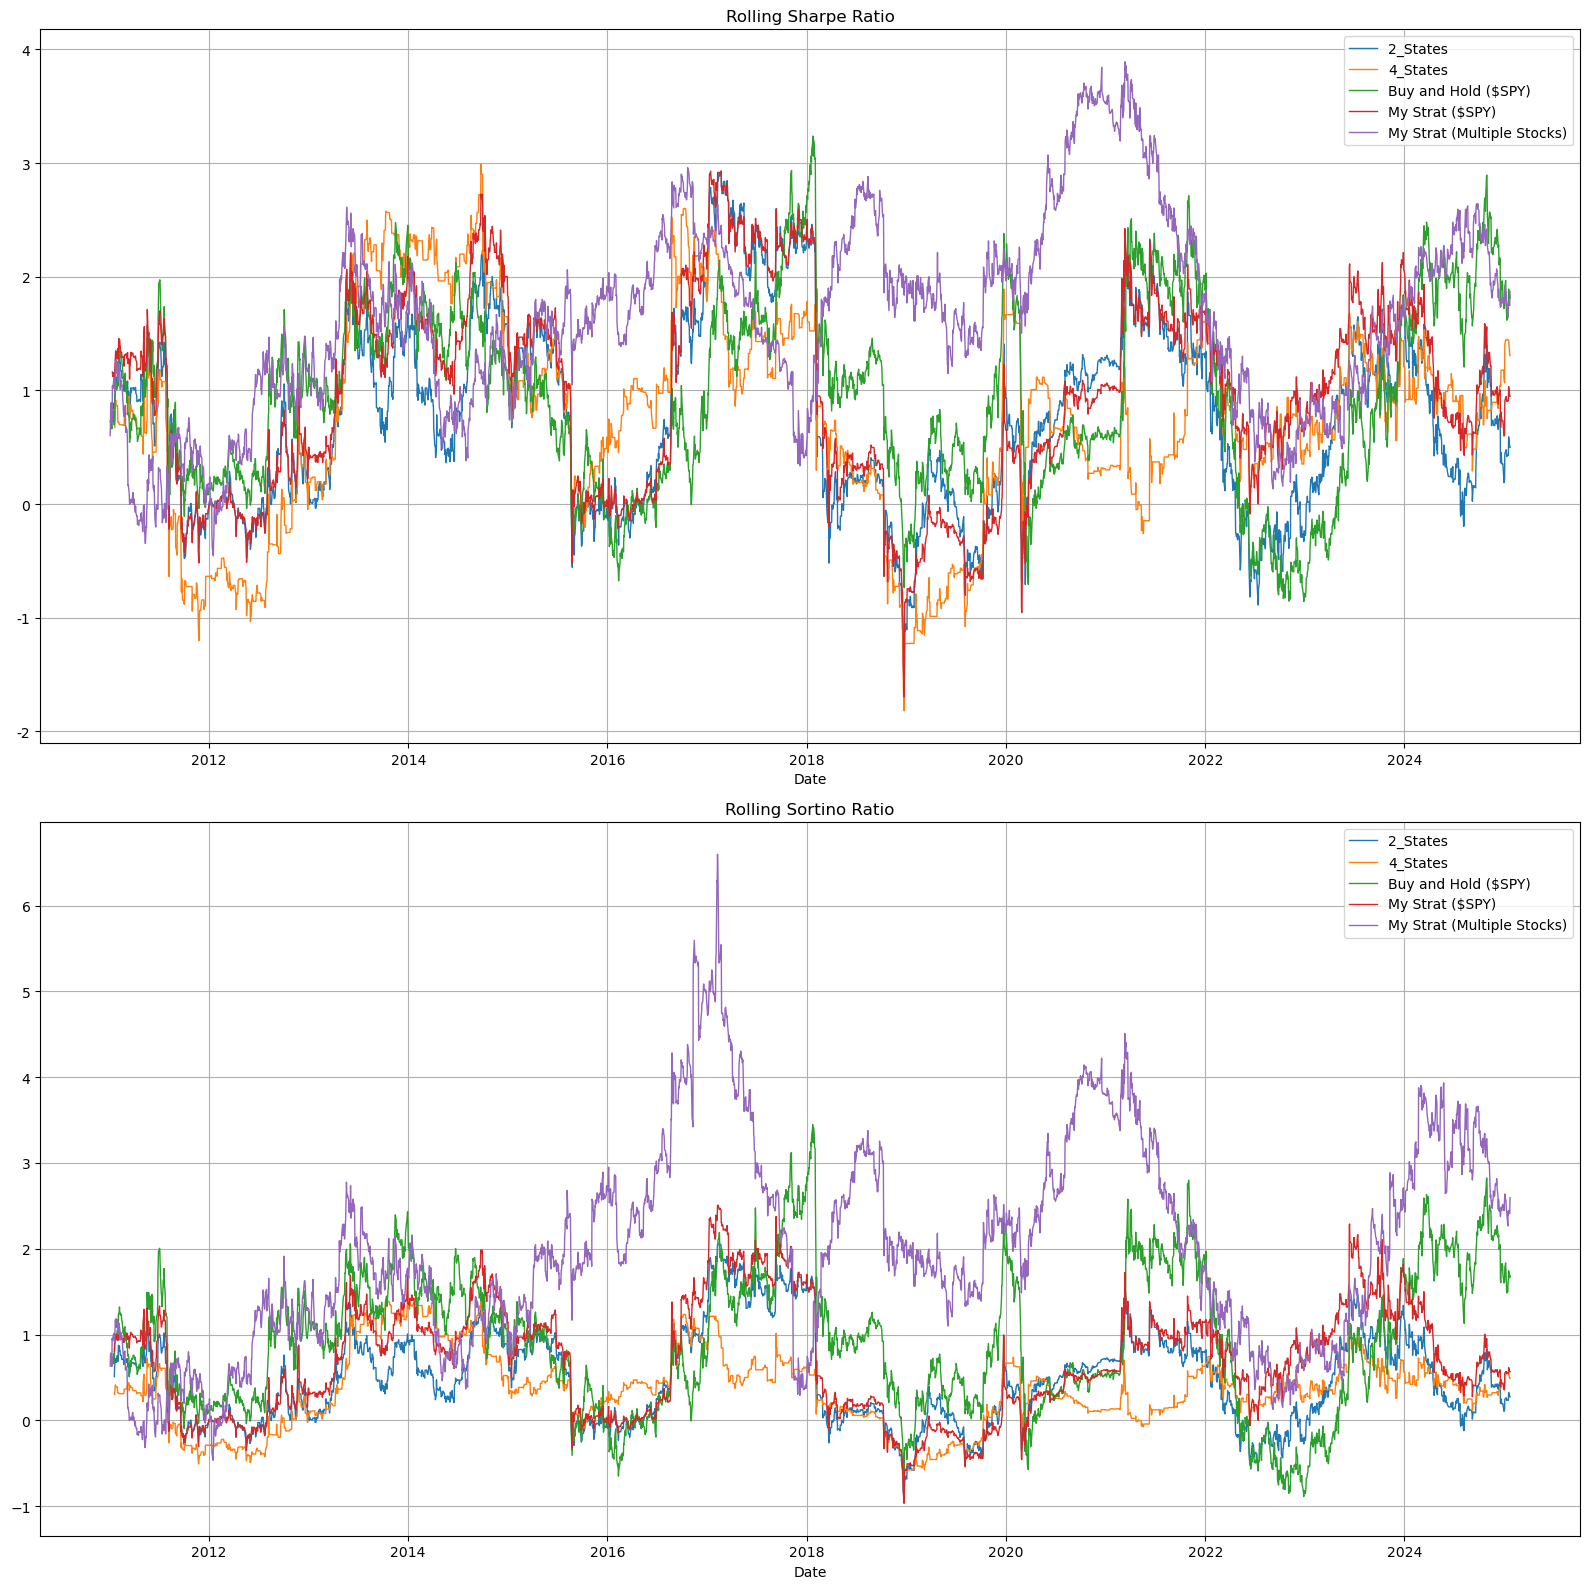

In [109]:
cash = 10000
ticker_symbol = "SPY"
start_date = "2010-01-01"
end_date = "2026-01-01"
ticker_symbols = ["NVDA", "MSFT", "DIS", "ORCL", "KO", "INTC", "MO"]
# ticker_symbols = ["SPY"]

multiplier = 1
max_relative = True

stock_data = download_stock_data(ticker_symbol, start_date, end_date)
kelly_percentages = calculate_kelly_criterion(stock_data)
print(f"Kelly Criterion (${ticker_symbol}): {kelly_percentages}")

state_columns = [col for col in stock_data.columns if re.match(r"^\d+_States$", col)]
state_numbers = [int(re.match(r"^(\d+)_States$", col).group(1)) for col in state_columns]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 16))
fig, (ax3, ax4) = plt.subplots(2, 1, figsize=(16, 16))

for state_column, state_number in zip(state_columns, state_numbers):
    if state_number in [2, 4]:
        date_record, equity_record, drawdown_record = simulate_strategy_using_states(cash, stock_data, state_number, multiplier=10000)
        sharpe_ratio = calculate_sharpe_ratio(equity_record)
        sortino_ratio = calculate_sortino_ratio(equity_record)
        print(f"For {state_column}")
        print(f" - Sharpe Ratio: {sharpe_ratio:.2f}")
        print(f" - Sortino Ratio: {sortino_ratio:.2f}")
        
        plot_states_comparison(ax1, ax2, state_column, date_record, equity_record, drawdown_record)
        plot_ratio_comparison(ax3, ax4, state_column, equity_record, date_record)
        annualized_return = calculate_annualized_return(date_record, equity_record)
        print(f" - Annualized Return: {annualized_return * 100:.2f}%")
    
date_record, equity_record, drawdown_record = simulate_buy_and_hold(cash, stock_data)
plot_states_comparison(ax1, ax2, f"Buy and Hold (${ticker_symbol})", date_record, equity_record, drawdown_record)
plot_ratio_comparison(ax3, ax4, f"Buy and Hold (${ticker_symbol})", equity_record, date_record)
sharpe_ratio = calculate_sharpe_ratio(equity_record)
sortino_ratio = calculate_sortino_ratio(equity_record)
print(f"For Buy and Hold")
print(f" - Sharpe Ratio: {sharpe_ratio:.2f}")
print(f" - Sortino Ratio: {sortino_ratio:.2f}")
annualized_return = calculate_annualized_return(date_record, equity_record)
print(f" - Annualized Return: {annualized_return * 100:.2f}%")

date_record, equity_record, drawdown_record = simulate_combined_strategy(cash, stock_data, multiplier, max_relative)
plot_states_comparison(ax1, ax2, f"My Strat (${ticker_symbol})", date_record, equity_record, drawdown_record)
plot_ratio_comparison(ax3, ax4, f"My Strat (${ticker_symbol})", equity_record, date_record)
sharpe_ratio = calculate_sharpe_ratio(equity_record)
sortino_ratio = calculate_sortino_ratio(equity_record)
print(f"For My Strategy")
print(f" - Sharpe Ratio: {sharpe_ratio:.2f}")
print(f" - Sortino Ratio: {sortino_ratio:.2f}")
annualized_return = calculate_annualized_return(date_record, equity_record)
print(f" - Annualized Return: {annualized_return * 100:.2f}%")

stock_data_list = []
for ticker_symbol in ticker_symbols:
    data = download_stock_data(ticker_symbol, start_date, end_date)
    stock_data_list.append(data)
date_record, equity_record, drawdown_record, trade_record = simulate_combined_strategy_basket(cash, stock_data_list, multiplier, max_relative)
plot_states_comparison(ax1, ax2, "My Strat (Multiple Stocks)", date_record, equity_record, drawdown_record)
plot_ratio_comparison(ax3, ax4, "My Strat (Multiple Stocks)", equity_record, date_record)
sharpe_ratio = calculate_sharpe_ratio(equity_record)
sortino_ratio = calculate_sortino_ratio(equity_record)
print(f"For My Strategy (Multiple Stocks)")
print(f" - Sharpe Ratio: {sharpe_ratio:.2f}")
print(f" - Sortino Ratio: {sortino_ratio:.2f}")
annualized_return = calculate_annualized_return(date_record, equity_record)
print(f" - Annualized Return: {annualized_return * 100:.2f}%")

plt.show()